In [1]:
from common.common_imports import *
from common.util import *
from data.dataloader import *

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [3]:
# PARAMS
batch_size = 1
test_size = 20
row_len = 12
days_pred_list = [5]
num_epochs = 2
max_src_window = 2000

# model
num_heads=2
num_encoder_layers=3
num_decoder_layers=3
dropout_p=0.1

# optim
lr = 0.05
max_grad_norm = 0.1

In [4]:
# DATALOADER
train_loader, test_loader = create_splits(
    batch_size=batch_size,
    test_size=test_size,
    reset_progress=True
)

In [5]:
# MODEL
model = torch.nn.Transformer(
    d_model=row_len,
    nhead=num_heads,
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    dropout=dropout_p,
    batch_first=True
    ).to(device)

In [6]:
batch, lengths = next(iter(train_loader))
MAX_SRC = 6000; DAYS_PRED = 5
_, src_padding_mask, tgt, exp = get_inputs(batch, lengths, MAX_SRC, DAYS_PRED)
for i in range(batch_size):
    # check that lengths is correct
    ### batch[:,i] = [0,0,0,...] iff i >= lengths[:]
    assert sum(batch[i, lengths[i]-1]) > 0
    assert batch.shape[1] == lengths[i] or sum(batch[i, lengths[i]]) == 0
# src_padding_mask[i] = False if i < len - days_pred - 1 else True
# tgt[0] = src_padding_mask[len-days_pred-1]
# tgt[-1] = batch[len-1-1]
# exp = batch[len-1]

  0%|          | 0/9226 [00:00<?, ?it/s]

255


<function matplotlib.pyplot.show(close=None, block=None)>

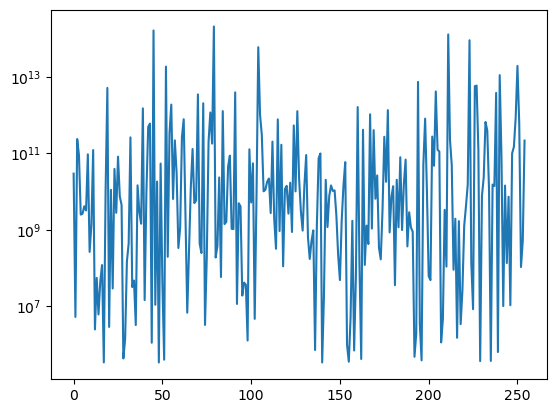

In [7]:
# TRAIN
opt = torch.optim.AdamW(model.parameters(), lr=lr)
loss_fn = torch.nn.MSELoss()

model.train()
torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

# UI
losses = []
i = -1
j = 0
total_iters = len(days_pred_list) * len(train_loader) * num_epochs
breaking = False
with tqdm(total=total_iters) as pbar:
    for epoch in range(num_epochs):
        if breaking: break
        for days_pred in days_pred_list:
            if breaking: break
            train_loader.dataset.reset_progress()
            for batch, lengths in train_loader:
                """batch: [batch_size, num_days, features_per_day]"""
                pbar.update(1)
                    
                src, src_padding_mask, tgt, exp = get_inputs(batch, lengths, max_src_window, days_pred)
                tgt_mask = get_tgt_mask(days_pred)
                src = src.to(device)
                src_padding_mask = src_padding_mask.to(device)
                tgt = tgt.to(device)
                tgt_mask = tgt_mask.to(device)
                exp = exp.to(device)

                out = model(src=src, src_key_padding_mask=src_padding_mask, tgt=tgt, tgt_mask=tgt_mask)
            
                loss = loss_fn(out, exp)
                
                i += 1
                if i % 10 == 0:
                    losses.append(loss.item())
                    i = 0
                    if loss.item() and loss.item() < float("inf"):
                        j += 1
                    else:
                        breaking = True
                        break

                opt.zero_grad()
                loss.backward()
                opt.step()

print(j) # 427, 46%
y = np.array(losses)

# x = np.arange(0, len(losses))
# coefficients = np.polyfit(x, np.log10(y), 1)
# trendline = np.polyval(coefficients, x)
# plt.semilogy(x, y)
# plt.plot(x, 10 ** trendline, 'r--', label='Trendline')


plt.plot(y)
plt.yscale("log")
plt.show